# Run from scratch
## Under Construction. Please run saved_results.ipynb
This Jupyter notebook describes the case study for the the autonomous systems case study. To run this notebook, you would need TuLiP, Cvxpy, the model checker Storm and its Python interface, Stormpy.

In [5]:
# Import libraries
from pacti.iocontract.utils import getVarlist
from PIL import Image
from pacti.terms.polyhedra import PolyhedralContract
import pdb
from case_study import * 
import random
import pickle as pkl
import os
import collections

`polytope` failed to import `cvxopt.glpk`.
will use `scipy.optimize.linprog`
`omega.symbolic.symbolic` failed to import `dd.cudd`.
Will use `dd.autoref`.
`tulip` failed to import `cvxopt`.
No quadratic cost for controller computation.


## Part 1: Example

In [6]:
# Parameters of car / pedestrian example:
N = 10 # number of cells in the grid, and the crosswalk is located one cell before the end of the lane.
Vmax = 3 # Maximum speed of car


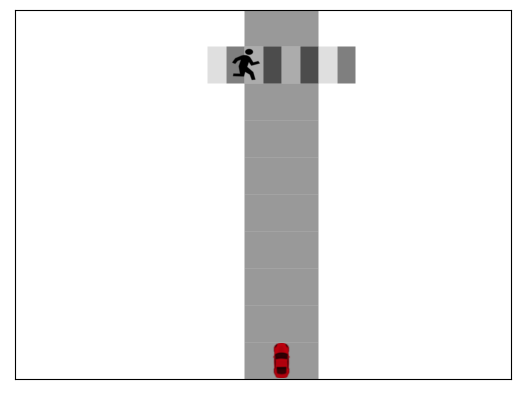

<Figure size 640x480 with 0 Axes>

In [8]:
TILESIZE = 50
ORIENTATIONS = {'n': 270, 'e': 0, 's': 90,'w':180, 'ne':315, 'nw':225, 'se':45, 'sw':135}
START_CROSSWALK = -1
END_CROSSWALK = 2
CROSSWALK_POS = 1
CROSSWALK_LOCATIONS = dict()
ped_loc = []
for i, num in enumerate(range(2*START_CROSSWALK,2*(END_CROSSWALK+1))):
    CROSSWALK_LOCATIONS.update({i: (num/2, CROSSWALK_POS)})
    ped_loc.append(num/2)
    
class GridCar():
    def __init__(self, N, Vmax):
        self.xc_init = 1
        self.vc_init = 1
        self.ped = 1
        self.N = N
        self.Vmax = Vmax
        self.xped = self.N-CROSSWALK_POS
        self.main_dir = os.path.dirname(os.path.dirname(os.path.realpath("__file__")))
        self.car_fig = self.main_dir + '/evaluating_perception/imglib/red_car.png'
        self.ped_fig = self.main_dir + '/evaluating_perception/imglib/pedestrian_img.png'
        self.car_data = [9, 0]
        if self.ped == 1:
            self.ped_data = [CROSSWALK_POS, min(ped_loc)]
        else:
            self.ped_data = None
    
    def dynamics(self):
        transitions = dict()
        for x in range(1, self.N+1):
            x_succ = []
            for v in range(0, self.Vmax):
                x_succ.append(x + v)
            transitions[x] = x_succ
        return transitions
    
    def plot_grid(self):
        size = [1, self.N]
        x_min = 0
        x_max = size[0] * TILESIZE
        y_min = 0
        y_max = size[1] * TILESIZE
        # x_min, x_max, y_min, y_max = get_map_corners(map)
        
        fig, ax = plt.subplots()
        ax.axis('equal')
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        # fill in the road regions
        road_tiles = []
        width_tiles = np.arange(0,size[0]+1)*2*TILESIZE
        lanes_tiles = np.arange(0,size[1]+1)*TILESIZE
        
        for i in np.arange(0,size[0]):
            for k in np.arange(0,size[1]+1):
                tile = patches.Rectangle((width_tiles[i],lanes_tiles[k]),2*TILESIZE,TILESIZE,linewidth=1,facecolor='k', alpha=0.4)
                road_tiles.append(tile)
        ax.add_collection(PatchCollection(road_tiles, match_original=True))

        # now add crosswalk on top
        crosswalk_tiles = []
        for item in CROSSWALK_LOCATIONS.keys():
            if item % 2 == 0:
                color = 'silver'
                alpha = 0.5
            else:
                color = 'k'
                alpha = 0.5
            width = CROSSWALK_LOCATIONS[item][0]*TILESIZE
            lanes = CROSSWALK_LOCATIONS[item][1]*TILESIZE
            tile = patches.Rectangle((width,lanes),TILESIZE/2,TILESIZE,linewidth=1,facecolor=color, alpha=alpha)
            crosswalk_tiles.append(tile)
        ax.add_collection(PatchCollection(crosswalk_tiles, match_original=True))
        # TODO: Add cross-walk tile names next to the cells
        plt.gca().invert_yaxis()
        return ax
    
    
    def plot_car(self, ax):
        y_tile, speed = self.car_data
        theta_d = 270 # Rotate car to face north
        x = (1) * TILESIZE/2
        y = (y_tile) * TILESIZE
        car_fig = Image.open(self.car_fig)
        car_fig = car_fig.rotate(theta_d, expand=False)
        offset = 0.1
        ax.imshow(car_fig, zorder=1, interpolation='bilinear', extent=[x+2, x+TILESIZE-2, y+2, y+TILESIZE-2])
        return ax
    
    def plot_ped(self, ax):
        y_tile, x_tile = self.ped_data
        x = (x_tile) * TILESIZE/2
        y = (y_tile) * TILESIZE
        ped_fig = Image.open(self.ped_fig)
        ped_fig = ped_fig.rotate(180, expand=False)
        offset = 0.1
        ax.imshow(ped_fig, zorder=1, interpolation='bilinear', extent=[x+4, x+TILESIZE-2, y+2, y+TILESIZE-2])
        return ax
    
    # Function to calculate all system states:
    def construct_transitions(self):
        T = dict()
        for xcar in range(1,self.N+1):
            for vcar in range(0, self.Vmax+1):
                st = (xcar, vcar)
                end_st = []
                if xcar == self.N:
                    end_st.append((xcar, vcar))
                elif vcar == 0:
                    xcar_p = min(self.N, xcar+1)
                    end_st.append((xcar, vcar))
                    end_st.append((xcar_p, vcar+1))
                    end_st.append((xcar, vcar+1))
                else:
                    xcar_p = min(self.N, xcar+vcar)
                    end_st.append((xcar_p, vcar))
                    end_st.append((xcar_p, vcar-1))
                    if vcar < Vhigh:
                        end_st.append((xcar_p, vcar+1))
                T[st] = end_st
        return T
    
    # System states for pedestrian
    def system_states_example_ped(self):
        nS = self.N*(self.Vmax+1)
        state = lambda x,v: (self.Vmax+1)*(x-1) + v
        state_to_S = dict()
        S = set()
        for xcar in range(1,self.N+1):
            for vcar in range(0, self.Vmax+1):
                st = "S"+str(state(xcar, vcar))
                state_to_S[xcar,vcar] = st
                S|={st}
        T = self.construct_transitions()
        return S, state_to_S, T


# Generate grid and figure:
grid = GridCar(N, Vmax)
ax = grid.plot_grid()
ax = grid.plot_car(ax)
ax = grid.plot_ped(ax)

plt.show()
plt.savefig(grid.main_dir + "/evaluating_perception/imglib/car_ped_ex.png")

## Part 2: Getting probability points for ped, obj, empty:

In [9]:
def bound_probs_lp(tpx, proby):
    '''
    Finding the tightest lower bound using linear programming. Maximize the area under the lower bound such that 
    for all sampled probabilities, the affine expression is a lower bound.
    '''
    l = min(tpx)
    u = max(tpx)
    m = cp.Variable()
    b = cp.Variable()

    alpha = (u**2 - l**2)/2
    beta = (u-l)
    obj =  alpha*m + beta*b
    n = len(tpx)

    A = np.array(tpx).reshape(1,-1)
    B = np.ones((n,1))
    C = np.array(proby).reshape(1,-1)

    constraints = [A*m + B*b <=C]
    prob = cp.Problem(cp.Maximize(obj), constraints)
    prob.solve()
    if prob.status == "infeasible" or prob.status == "unbounded":
        pdb.set_trace()
    else:
        lb = [m.value, b.value]
        ub = []
        return ub, lb


def derive_prob_bounds_lp(fn, true_env):
    points, tp_vals = load_result(fn)
    result_tuple = [[tp_vals[i],points[i]] for i in range(len(tp_vals))]
    if true_env == "ped":
        ub, lb = bound_probs_lp(tp_vals, points)
    elif true_env == "obj":
        ub, lb = bound_probs_lp(tp_vals, points)
    else:
        ub, lb = bound_probs_lp(tp_vals, points)
    return ub, lb, points, tp_vals

In [5]:
# Here we load probability points from saved pickle files. To recompute the probabilities, then set recompute to True
Vlow = 0
Vhigh = Vmax
recompute = False

# Sampling satisfaction probabilities:
xped, bad_states_ped, good_state_ped, formula = initialize(vmax, N, "ped")
points_ped, tpped_vals = gen_points(N, Vlow, Vhigh, xped, bad_states_ped, good_state_ped, formula, Vmax)
fn = save_result(points_ped, tpped_vals, "ped", vmax, Ncar)
ubounds_ped, lbounds_ped, points_ped, tpped_vals = derive_prob_bounds_lp(fn, "ped")

xped, bad_states_ped, good_state_ped, formula = initialize(Vmax, N, "obj")
points_obj, tpobj_vals = gen_points_obj(N, Vlow, Vhigh, xped, bad_states_ped, good_state_ped, formula, Vmax)
fn = save_result(points_obj, tpobj_vals, "obj", Vmax, N)
ubounds_obj, lbounds_obj, points_obj, tpobj_vals = derive_prob_bounds_lp(fn, "obj")

xped, bad_states_ped, good_state_ped, formula = initialize(Vmax, N, "emp")
points_emp, tpemp_vals = gen_points_emp(N, Vlow, Vhigh, xped, bad_states_ped, good_state_ped, formula, Vmax)
fn = save_result(points_emp, tpemp_vals, "emp", Vmax, N)
ubounds_emp, lbounds_emp, points_emp, tpemp_vals = derive_prob_bounds_lp(fn, "emp")

In [ ]:
# Plotting Probabilities:
def plot_probabilities_bounds(points, tp_vals, ubounds, lbounds, true_env):
    fig, ax = plt.subplots()
    ax.tick_params(axis='both', which='major', labelsize=10)
    plt.plot(tp_vals, points, 'b*',label='sampled')
    if ubounds != []:
        ub_m, ub_c = ubounds
        y_ub = ub_m*np.array(tp_vals) + ub_c
        plt.plot(tp_vals, y_ub, 'r')
        
    lb_m, lb_c = lbounds
    y_lb = lb_m*np.array(tp_vals) + lb_c
    plt.plot(tp_vals, y_lb, 'k',label='lower bound',linewidth=4)
    lb = min(tp_vals)
    ub = max(tp_vals)
    plt.legend(prop={'size': 10})
    
    plt.title('Lower bound of $\mathbb{P}_{'+true_env+'}$ as a function of $\mathtt{TP}_{'+true_env+'}$.')
    plt.ylabel('$\mathbb{P}_{'+true_env+'}$')
    plt.xlabel('$\mathtt{TP}_{'+true_env+'}$')

plot_probabilities_bounds(points_ped, tpped_vals, [], lbounds_ped, "ped")
plot_probabilities_bounds(points_obj, tpobj_vals, [], lbounds_obj, "obj")
plot_probabilities_bounds(points_emp, tpemp_vals, [], lbounds_emp, "emp")

## Part 3: Controller Contracts

In [6]:
## Lower bounds only:
# First we construct each contract individually, and then merge the controller contract:
## Control contract for pedestrian class
def control_contract_ped(lbounds_ped):
    lb_m, lb_c = lbounds_ped
    mc= dict()
    mc = {"input_vars":["tp_ped", "tp_obj", "tp_emp"],
        "output_vars":[
            "P_ped", "P_obj", "P_emp"
        ],
        "assumptions":
        [
            {"coefficients":{"tp_ped":-1},
            "constant":-0.6}
        ],
        "guarantees":
        [
#           {"coefficients":{"P_ped":1, "tp_ped":-1*ub_m},
#           "constant":ub_c},
          {"coefficients":{"P_ped":-1, "tp_ped":lb_m},
          "constant":-1*lb_c}
        ]}
    return mc

def control_contract_obj(lbounds_obj):
    lb_m, lb_c = lbounds_obj
    mc= dict()
    mc = {"input_vars":["tp_ped", "tp_obj", "tp_emp"],
        "output_vars":[
            "P_ped", "P_obj", "P_emp"
        ],
        "assumptions":
        [
#             {"coefficients":{"tp_obj":1},
#             "constant":0.999},
            {"coefficients":{"tp_obj":-1},
            "constant":-0.3}
        ],
        "guarantees":
        [
#           {"coefficients":{"P_obj":1, "tp_obj":-1*ub_m},
#           "constant":ub_c},
          {"coefficients":{"P_obj":-1, "tp_obj":lb_m},
          "constant":-1*lb_c}
        ]}
    return mc

def control_contract_emp(lbounds_emp):
    lb_m, lb_c = lbounds_emp
    mc= dict()
    mc = {"input_vars":["tp_ped", "tp_obj", "tp_emp"],
        "output_vars":[
            "P_ped", "P_obj", "P_emp"
        ],
        "assumptions":
        [
#             {"coefficients":{"tp_emp":1},
#             "constant":0.999},
            {"coefficients":{"tp_emp":-1},
            "constant":-0.6}
        ],
        "guarantees":
        [
#           {"coefficients":{"P_emp":1, "tp_emp":-1*ub_m},
#           "constant":ub_c},
          {"coefficients":{"P_emp":-1, "tp_emp":lb_m},
          "constant":-1*lb_c}
        ]}
    return mc

Cped = PolyhedralContract.from_dict(control_contract_ped(lbounds_ped))
Cobj = PolyhedralContract.from_dict(control_contract_obj(lbounds_obj))
Cemp = PolyhedralContract.from_dict(control_contract_emp(lbounds_emp))

print("Controller Contract for pedestrian class:\n" + str(Cped) + "\n")
print("Controller Contract for object class:\n" + str(Cobj)+ "\n")
print("Controller Contract for empty class:\n" + str(Cemp)+ "\n")


Controller Contract for pedestrian class:
InVars: [<Var tp_ped>, <Var tp_obj>, <Var tp_emp>]
OutVars:[<Var P_ped>, <Var P_obj>, <Var P_emp>]
A: -1*tp_ped <= -0.6
G: -1.0*P_ped + 1.5801256015029996*tp_ped <= 0.6220524909016469

Controller Contract for object class:
InVars: [<Var tp_ped>, <Var tp_obj>, <Var tp_emp>]
OutVars:[<Var P_ped>, <Var P_obj>, <Var P_emp>]
A: -1*tp_obj <= -0.3
G: -1.0*P_obj + 0.06834814849496082*tp_obj <= -0.9288940771532732

Controller Contract for empty class:
InVars: [<Var tp_ped>, <Var tp_obj>, <Var tp_emp>]
OutVars:[<Var P_ped>, <Var P_obj>, <Var P_emp>]
A: -1*tp_emp <= -0.6
G: -1.0*P_emp + 0.20049999999999998*tp_emp <= -0.7996999999999667



In [7]:
# Construct merger of contracts:
C_controller = Cped.merge(Cobj) 
C_controller = C_controller.merge(Cemp)

print("Merged Controller Contract for all object classes:\n" + str(C_controller) + "\n")

Merged Controller Contract for all object classes:
InVars: [<Var tp_ped>, <Var tp_obj>, <Var tp_emp>]
OutVars:[<Var P_ped>, <Var P_obj>, <Var P_emp>]
A: -1*tp_ped <= -0.6, -1*tp_obj <= -0.3, -1*tp_emp <= -0.6
G: -1.0*P_ped + 1.5801256015029996*tp_ped <= 0.6220524909016469, -1.0*P_obj + 0.06834814849496082*tp_obj <= -0.9288940771532732, -1.0*P_emp + 0.20049999999999998*tp_emp <= -0.7996999999999667



In [8]:
## System contract: P >= 0.99
def system_contract_dist():
    system_contract = {
        "input_vars":[
            "d"
        ],
        "output_vars":[
            "P_ped", "P_obj", "P_emp"
        ],
        "assumptions":
        [
            {"coefficients":{"d":-1}, "constant":0},
            {"coefficients":{"d":1}, "constant":10}
        ],
        "guarantees":
        [
            {"coefficients":{"P_ped":-1, "d":-0.099},
            "constant":-0.99},
#             {"coefficients":{"P_ped":1, "d":0.00},
#             "constant":1},
            {"coefficients":{"P_obj":-1, "d":-0.08},
            "constant":-0.8},
#             {"coefficients":{"P_obj":1, "d":0},
#             "constant":1},
            {"coefficients":{"P_emp":-1, "d":-0.095},
            "constant":-0.95},
#             {"coefficients":{"P_emp":1, "d":0.0},
#             "constant":1}
        ]}
    return system_contract

Csys_dist = PolyhedralContract.from_dict(system_contract_dist())
print("System Contract (distance bounds):\n" + str(Csys_dist) + "\n")

System Contract (distance bounds):
InVars: [<Var d>]
OutVars:[<Var P_ped>, <Var P_obj>, <Var P_emp>]
A: -1*d <= 0.0, 1*d <= 10.0
G: -1.0*P_ped + -0.099*d <= -0.99, -1.0*P_obj + -0.08*d <= -0.8, -1.0*P_emp + -0.095*d <= -0.95



In [8]:
# Computing quotient contract:
C_dist = Csys_dist.quotient(C_controller)
print("Quotient Contract with distance bounds on true positive rates:\n" + str(C_dist)+"\n")

Quotient Contract with distance bounds on true positive rates:
InVars: [<Var d>]
OutVars:[<Var tp_ped>, <Var tp_obj>, <Var tp_emp>]
A: -1*d <= 0.0, 1*d <= 10.0
G: -0.099*d + -1.58012560150300*tp_ped <= -1.61205249090165, -0.095*d + -0.200500000000000*tp_emp <= -0.150300000000033, -1*tp_ped <= -0.6, -1*tp_obj <= -0.30000000000000004, -1*tp_emp <= -0.6

